# Playground 4:  Segmentation workflows for curvi-linear structures

This notebook contains the workflows for Sec61 beta, Tom20 and lamin B1 (mitosis-specific), and serves as a starting point for developing a classic segmentation workflow for your data with curvilinear shapes.

----------------------------------------

Cell Structure Observations:

* [Sec61 beta](https://www.allencell.org/cell-observations/category/sec61)

* [Tom20](https://www.allencell.org/cell-observations/category/tom20)

* [Lamin B1](https://www.allencell.org/cell-observations/category/lamin)

----------------------------------------

Key steps of the workflows:

* Min-max intensity normalization / Auto-contrast
* 3D Gaussian smoothing 
* 2D filament filter 
* size thresholding

In [1]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage, omeTifWriter                            

# function for core algorithm
from aicssegmentation.core.vessel import filament_2d_wrapper
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d, edge_preserving_smoothing_3d
from skimage.morphology import remove_small_objects     # function for post-processing (size filter)

## Loading the data

In [2]:
FILE_NAME = '/allen/aics/assay-dev/Segmentation/DeepLearning/for_april_2019_release/demo1/original/20190204_C01_002-Scene-03-P2-F02.czi'
reader = AICSImage(FILE_NAME) 
IMG = reader.data

print(IMG.shape)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(1, 4, 65, 624, 924)


## Preview of the image

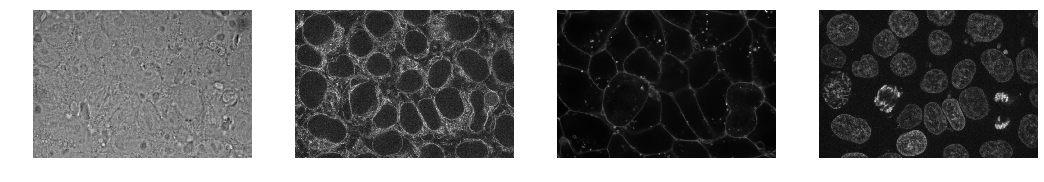

In [3]:
N_CHANNELS = IMG.shape[1]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS>1:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)

In [4]:
#####################
structure_channel = 1
#####################

structure_img0 = IMG[0,structure_channel,:,:,:]
view(single_fluorescent_view(structure_img0))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f40f90526…

## Image segmentation

### Step 1: Pre-Processing

About selected algorithms and tuned parameters

* **Intensity normalization**

Parameter for Sec61 beta:  `intensity_scaling_param = [2.5, 7.5]`

Parameter for Tom20:  `intensity_scaling_param = [3.5, 15]`

Parameter for Lamin B1 (mitosis specific):  `intensity_scaling_param = [4000]`

About this parameter `intensity_scaling_param = [A, B]`: Here, `A` and `B` are non-negative values indicating that the full intensity range of the stack will first be cut-off into **[mean - A * std, mean + B * std]** and then rescaled to **[0, 1]**. The smaller the values of `A` and `B` are, the higher the contrast will be.
 
For lamin B1, we use min-max Normalization with an absolute intensity upper bound.

* **Smoothing** 

For Sec61 beta:

`edge_preserving_smoothing()`, no parameter

For Tom20 and Lamin B1:

3D gaussian smoothing with `gaussian_smoothing_sigma = 1`. The large the value is, the more the image will be smoothed. 

In [8]:
################################
## PARAMETERS for this step ##
intensity_scaling_param = [2.5, 7.0]
gaussian_smoothing_sigma = 1
################################
# intensity normalization
structure_img = intensity_normalization(structure_img0, scaling_param=intensity_scaling_param)

# smoothing with 2d gaussian filter slice by slice 
#structure_img_smooth = image_smoothing_gaussian_3d(structure_img, sigma=gaussian_smoothing_sigma)

# Or, edge-preserving smoothing
structure_img_smooth = edge_preserving_smoothing_3d(structure_img)

intensity normalization: normalize into [mean - 2.5 x std, mean + 7.0 x std] 
intensity normalization completes


In [9]:
view(single_fluorescent_view(structure_img_smooth))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f40d559cd…

#### If the contrast looks too off, you can tune the normalization parameters.

We have a function to give you some suggestions. If you have certain preference, you can adjust the values based on the suggestion.

***After you decide the parameters, you have to re-run the code above with the new parameter*** `intensity_scaling_param = ` 

In [7]:
from aicssegmentation.pre_processing_utils import suggest_normalization_param
suggest_normalization_param(structure_img0)

mean intensity of the stack: 434.41234219839987
the standard deviation of intensity of the stack: 28.131202961548066
0.9999 percentile of the stack intensity is: 645.0
minimum intensity of the stack: 363
maximum intensity of the stack: 645
suggested upper range is 7.0, which is 631.3307629292364
suggested lower range is 2.5, which is 364.0843347945297
So, suggested parameter for normalization is [2.5, 7.0]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


### Step 2: Core Algorithm

#### apply 2d filament filter 

Parameter syntax: `[[scale_1, cutoff_1], [scale_2, cutoff_2], ....]` 
* `scale_x` is set based on the estimated width of your target curvilinear shape. For example, if visually the width of the objects is usually 3~4 pixels, then you may want to set `scale_x` as `1` or something near `1` (like `1.25`). Multiple scales can be used, if you have objects of very different sizes.  
* `cutoff_x` is a threshold applied on the actual filter reponse to get the binary result. Smaller `cutoff_x` may yielf fatter segmentation, while larger `cutoff_x` could be less permisive and yield less objects and slimmer segmentation. 

Parameter for Sec61 beta:  `f2_param = [[1, 0.15]]`

Parameter for tom20:  `f2_param = [[1.5, 0.16]]`

Parameter for lamin b1 (mitosis-specific):  `f2_param = [[0.5, 0.01]]`

In [14]:
################################
## PARAMETERS for this step ##
f2_param = [[1, 0.25]]
################################

bw = filament_2d_wrapper(structure_img_smooth, f2_param)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [15]:
viewer_bw = view(segmentation_quick_view(bw))
viewer_bw

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7f40d55a…

##### After quickly visualizing the segmentation results, you can also visualize the segmentation and original image side by side
##### You may select an ROI to inspect the details

* Option 1: Easy ROI selection, but NOT recommended if you are using a laptop

You can select an ROI in above visualization ('viewer_bw'); otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

* Option 2: Manually type in ROI coordinates

Type in the coordinates of upper left corner and lower right corner of the ROI in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]. 

In [16]:
# Option 1:
view(seg_fluo_side_by_side(structure_img,bw,roi=['ROI',viewer_bw.roi_slice()]))

# Option 2: 
#view(seg_fluo_side_by_side(structure_img,bw,roi=['M',[570,370,730,440]]))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f40d55ac2…

##### Is the segmentation satisfactory? Here are some possible criteria:

* Is there any object should be detected but not? Try to reduce `cutoff_x`
* Is there any object should not be detected but actually appear in the result? Try to increase `cutoff_x` or try a larger `scale_x`
* Is the segmented width of the objects is fatter than it should be? Try to increase `cutoff_x` or try a smaller `scale_x`
* Is there any object that should be solid but segmented as fragmented pieces? Try to increase `scale_x`
* Are you observing objects with very different width? Try multiple sets of `scale_x` and `cutoff_x` 

#### Step 3: Post-Processing 

In [17]:
################################
## PARAMETERS for this step ##
minArea = 5
################################

final_seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

## Result inspection

In [18]:
viewer_final = view(segmentation_quick_view(final_seg))
viewer_final

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7f40d55a…

### You can also focus your inspection on a small ROI

* Option 1: Easy ROI selection, but NOT recommended if you are using a laptop

You can select an ROI in above visualization ('viewer_final'); otherwise, the default ROI is the full image

[See this video for How to select ROI](https://www.youtube.com/watch?v=ZO8ey6-tF_0&index=3&list=PL2lHcsoU0YJsh6f8j2vbhg2eEpUnKEWcl)

* Option 2: Manually type in ROI coordinates

Type in the coordinates of upper left corner and lower right corner of the ROI in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y].

In [13]:
# Option 1: 
# view(seg_fluo_side_by_side(structure_img, final_seg, roi=['ROI',viewer_final.roi_slice()]))

# Option 2: 
view(seg_fluo_side_by_side(structure_img, final_seg, roi=['M',[267,474, 468, 605]]))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkIma…

### You may also physically save the segmentation results into a ome.tif file

In [14]:
final_seg = final_seg >0
out=final_seg.astype(np.uint8)
out[out>0]=255
writer = omeTifWriter.OmeTifWriter('../../data/Sec61b/result/3500002119_100X_20180703_3-Scene-05-P18-C09_test_segmentation.tiff')
writer.save(out)